## Preprocessing

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 148 µs (started: 2021-10-08 13:50:38 +00:00)


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive
time: 16.1 s (started: 2021-10-08 13:50:38 +00:00)


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7

time: 2.22 s (started: 2021-10-08 13:50:55 +00:00)


In [5]:
import os
path = "/content/gdrive/MyDrive/ComputerVision"
os.chdir(path)

time: 2.04 ms (started: 2021-10-08 13:50:57 +00:00)


In [6]:
TARGET_HEIGHT = 224
TARGET_WIDTH = 224
BATCH_SIZE = 16
VALIDATION_SPLIT= 0.05
EPOCHS = 15
NORMALIZE = False

time: 1.16 ms (started: 2021-10-08 13:50:57 +00:00)


In [7]:
def create_dataset(folder,subset,BATCH_SIZE,TARGET_HEIGHT,TARGET_WIDTH,validation_split=0.05 ,seed=1234,label_mode='categorical'):    
    dataset = tf.keras.preprocessing.image_dataset_from_directory(folder,
                                                                  subset=subset,
                                                                  validation_split=validation_split,
                                                                  seed=seed,
                                                                  label_mode=label_mode,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=(TARGET_HEIGHT,TARGET_WIDTH)
                                                                  )
    return dataset

time: 2.48 ms (started: 2021-10-08 13:50:57 +00:00)


In [8]:
train_folder='train'
train_dataset = create_dataset(train_folder,
                               subset='training',
                               BATCH_SIZE=BATCH_SIZE,
                               TARGET_HEIGHT=TARGET_HEIGHT,
                               TARGET_WIDTH=TARGET_WIDTH,
                               validation_split=VALIDATION_SPLIT)
class_names = train_dataset.class_names
num_classes = len(class_names)

Found 5641 files belonging to 10 classes.
Using 5359 files for training.
time: 9.94 s (started: 2021-10-08 13:50:57 +00:00)


In [9]:
valid_dataset = create_dataset(train_folder,subset='validation',BATCH_SIZE=BATCH_SIZE,TARGET_HEIGHT=TARGET_HEIGHT,TARGET_WIDTH=TARGET_WIDTH,validation_split=VALIDATION_SPLIT)

Found 5641 files belonging to 10 classes.
Using 282 files for validation.
time: 344 ms (started: 2021-10-08 13:51:07 +00:00)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


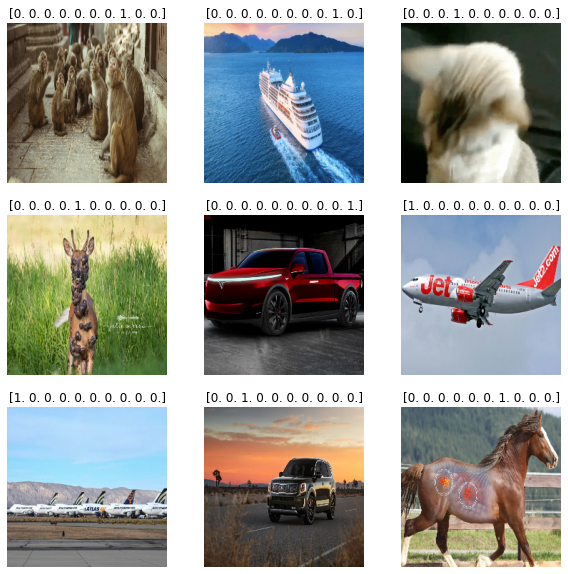

time: 39.5 s (started: 2021-10-08 13:51:07 +00:00)


In [10]:
plt.figure(figsize=(10, 10))
no_images_display = 9
for tensor, labels in train_dataset.take(1):    
    for index, image in enumerate(tensor):
        if index<no_images_display:
            ax = plt.subplot(3, 3, index + 1)
            plt.imshow(tensor[index].numpy().astype("uint8"))
            plt.title(labels[index].numpy())
            plt.axis("off")


## Image Preprocessing

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(AUTOTUNE)

time: 4.32 ms (started: 2021-10-08 13:51:47 +00:00)


# Tensorflow Implementation & importing EffiecientNetB7

In [12]:
def create_model(TARGET_HEIGHT,TARGET_WIDTH):
    input_shape = (TARGET_HEIGHT,TARGET_WIDTH,3)
    model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=input_shape)
    
    for layer in model.layers:
        layer.trainable = False

    flat_layer = layers.Flatten()(model.layers[-1].output)
    drop_layer = layers.Dropout(0.85)(flat_layer)     
    class_layer = layers.Dense(1024,activation='relu')(drop_layer)
    
    output = layers.Dense(num_classes, activation='softmax',name='Classification')(class_layer)
    model= Model(inputs=model.inputs,outputs=output)
    model.summary()
    return model

time: 6.46 ms (started: 2021-10-08 13:51:47 +00:00)


In [13]:
model = create_model(TARGET_HEIGHT=TARGET_HEIGHT,TARGET_WIDTH=TARGET_WIDTH)

258088960/258076736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________

In [14]:
def compile_model(model):
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        optimizer=optimizers.SGD(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()])
    print("Model has been compiled!")

time: 1.47 ms (started: 2021-10-08 13:51:55 +00:00)


In [15]:
compile_model(model)

Model has been compiled!
time: 25.1 ms (started: 2021-10-08 13:51:55 +00:00)


In [16]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

time: 962 µs (started: 2021-10-08 13:51:55 +00:00)


In [17]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="Checkpoint",monitor="val_loss")


time: 971 µs (started: 2021-10-08 13:51:55 +00:00)


In [18]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=model_checkpoint_callback)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


168/168 [==============================] - 801s 5s/step - loss: 0.6510 - categorical_accuracy: 0.8733 - val_loss: 0.0958 - val_categorical_accuracy: 0.9681


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
168/168 [==============================] - 42s 248ms/step - loss: 0.1626 - categorical_accuracy: 0.9522 - val_loss: 0.0813 - val_categorical_accuracy: 0.9681


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
168/168 [==============================] - 42s 247ms/step - loss: 0.1073 - categorical_accuracy: 0.9677 - val_loss: 0.0808 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/15
168/168 [==============================] - 41s 245ms/step - loss: 0.0815 - categorical_accuracy: 0.9756 - val_loss: 0.0729 - val_categorical_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/15
168/168 [==============================] - 41s 246ms/step - loss: 0.0607 - categorical_accuracy: 0.9828 - val_loss: 0.0561 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
168/168 [==============================] - 41s 244ms/step - loss: 0.0560 - categorical_accuracy: 0.9821 - val_loss: 0.0705 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
168/168 [==============================] - 41s 246ms/step - loss: 0.0455 - categorical_accuracy: 0.9845 - val_loss: 0.0527 - val_categorical_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
168/168 [==============================] - 41s 245ms/step - loss: 0.0363 - categorical_accuracy: 0.9869 - val_loss: 0.0580 - val_categorical_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
168/168 [==============================] - 41s 244ms/step - loss: 0.0336 - categorical_accuracy: 0.9905 - val_loss: 0.0538 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/15
168/168 [==============================] - 41s 245ms/step - loss: 0.0359 - categorical_accuracy: 0.9882 - val_loss: 0.0425 - val_categorical_accuracy: 0.9858


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/15
168/168 [==============================] - 41s 245ms/step - loss: 0.0346 - categorical_accuracy: 0.9897 - val_loss: 0.0348 - val_categorical_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/15
168/168 [==============================] - 41s 244ms/step - loss: 0.0276 - categorical_accuracy: 0.9897 - val_loss: 0.0408 - val_categorical_accuracy: 0.9858


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/15
168/168 [==============================] - 41s 244ms/step - loss: 0.0238 - categorical_accuracy: 0.9923 - val_loss: 0.0319 - val_categorical_accuracy: 0.9858


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/15
168/168 [==============================] - 41s 243ms/step - loss: 0.0268 - categorical_accuracy: 0.9910 - val_loss: 0.0669 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/15
168/168 [==============================] - 41s 243ms/step - loss: 0.0195 - categorical_accuracy: 0.9922 - val_loss: 0.0417 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


time: 46min 26s (started: 2021-10-08 13:51:55 +00:00)


### Unfreezing the last 20 layers and re-running the model with the layers 

In [19]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
        
    )


unfreeze_model(model)

time: 25.4 ms (started: 2021-10-08 14:38:22 +00:00)


In [20]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=model_checkpoint_callback)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


168/168 [==============================] - 74s 292ms/step - loss: 0.6014 - categorical_accuracy: 0.9371 - val_loss: 0.0830 - val_categorical_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
168/168 [==============================] - 45s 270ms/step - loss: 0.1849 - categorical_accuracy: 0.9690 - val_loss: 0.1264 - val_categorical_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
168/168 [==============================] - 46s 271ms/step - loss: 0.0725 - categorical_accuracy: 0.9866 - val_loss: 0.1753 - val_categorical_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/15
168/168 [==============================] - 46s 271ms/step - loss: 0.0538 - categorical_accuracy: 0.9909 - val_loss: 0.2021 - val_categorical_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/15
168/168 [==============================] - 46s 274ms/step - loss: 0.0464 - categorical_accuracy: 0.9916 - val_loss: 0.1117 - val_categorical_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
168/168 [==============================] - 46s 274ms/step - loss: 0.0651 - categorical_accuracy: 0.9894 - val_loss: 0.0808 - val_categorical_accuracy: 0.9823


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
168/168 [==============================] - 45s 271ms/step - loss: 0.0542 - categorical_accuracy: 0.9890 - val_loss: 0.1715 - val_categorical_accuracy: 0.9610


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
168/168 [==============================] - 46s 271ms/step - loss: 0.0811 - categorical_accuracy: 0.9888 - val_loss: 0.1005 - val_categorical_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
168/168 [==============================] - 46s 272ms/step - loss: 0.0390 - categorical_accuracy: 0.9925 - val_loss: 0.0852 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/15
168/168 [==============================] - 49s 292ms/step - loss: 0.0609 - categorical_accuracy: 0.9914 - val_loss: 0.1589 - val_categorical_accuracy: 0.9752


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/15
168/168 [==============================] - 46s 273ms/step - loss: 0.0632 - categorical_accuracy: 0.9916 - val_loss: 0.0856 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/15
168/168 [==============================] - 46s 272ms/step - loss: 0.0469 - categorical_accuracy: 0.9938 - val_loss: 0.1747 - val_categorical_accuracy: 0.9716


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/15
168/168 [==============================] - 46s 273ms/step - loss: 0.0564 - categorical_accuracy: 0.9927 - val_loss: 0.1939 - val_categorical_accuracy: 0.9681


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/15
168/168 [==============================] - 46s 271ms/step - loss: 0.0250 - categorical_accuracy: 0.9937 - val_loss: 0.1440 - val_categorical_accuracy: 0.9716


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/15
168/168 [==============================] - 46s 271ms/step - loss: 0.0394 - categorical_accuracy: 0.9933 - val_loss: 0.1326 - val_categorical_accuracy: 0.9787


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


time: 43min 22s (started: 2021-10-08 14:38:22 +00:00)


## Saving the model weights

The code below loads a previously saved model from directory

In [21]:
model_directory = 'models'
model_name = 'model.h5'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model.save_weights(f"{model_directory}/{model_name}")
print("Saved model to disk")

Saved model to disk
time: 1min 4s (started: 2021-10-08 15:21:44 +00:00)


# Charts

### History for Loss

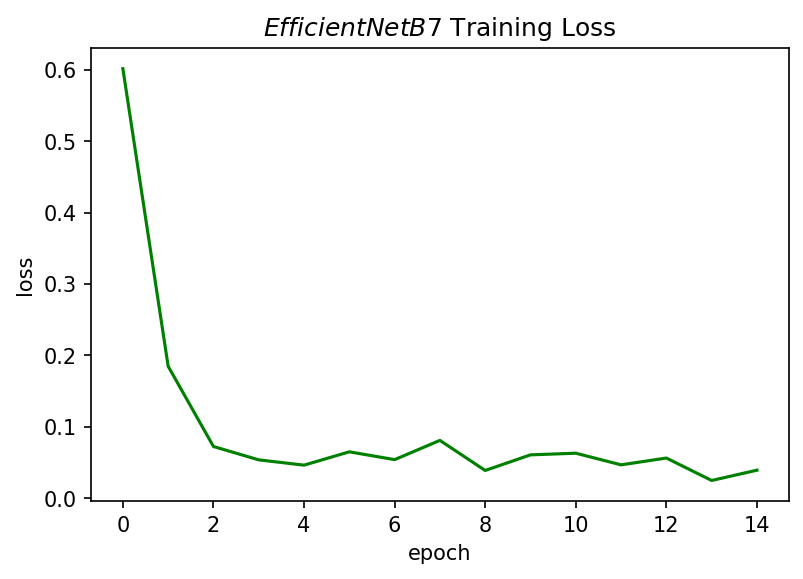

time: 2.2 s (started: 2021-10-08 15:22:48 +00:00)


In [22]:
# Summarizing the history for Loss

plt.figure(dpi=150)
plt.plot(history.history['loss'], 'g')
plt.title('$EfficientNetB7$ Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
if not os.path.exists('charts'):
    os.makedirs('charts')

plt.savefig("charts/history_loss.jpeg")
plt.show()

### History for Categorical Accuracy

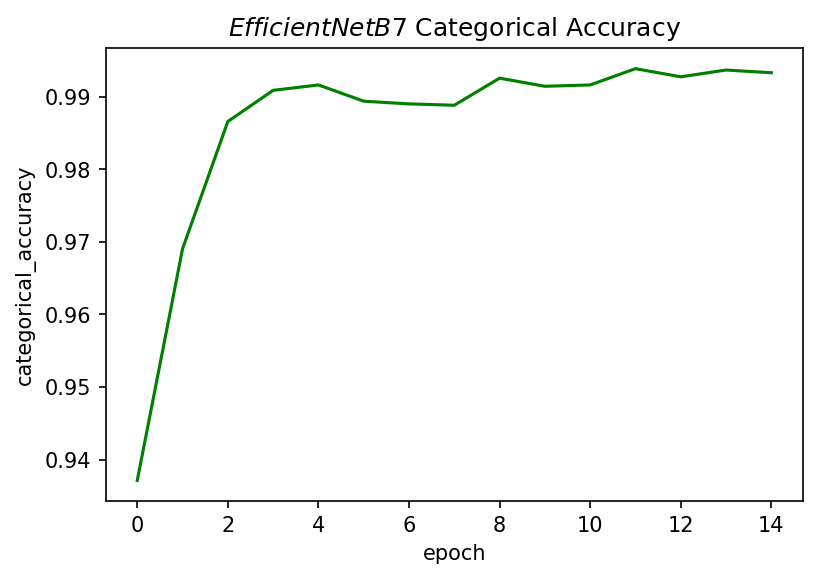

time: 817 ms (started: 2021-10-08 15:22:50 +00:00)


In [23]:
# Summarizing the history for Accuracy
metric = 'categorical_accuracy'

plt.figure(dpi=150)
plt.plot(history.history[metric], 'g')
plt.title(f'$EfficientNetB7$ Categorical Accuracy')

plt.ylabel(metric)
plt.xlabel('epoch')
if not os.path.exists('charts'):
    os.makedirs('charts')

plt.savefig(f"charts/Categorical Accuracy.jpeg")
plt.show()

In [24]:
history.history

{'categorical_accuracy': [0.9371151328086853,
  0.9690240621566772,
  0.9865646362304688,
  0.9908565282821655,
  0.991602897644043,
  0.9893636703491211,
  0.9889904856681824,
  0.9888038635253906,
  0.9925359487533569,
  0.991416335105896,
  0.991602897644043,
  0.9938421249389648,
  0.9927225112915039,
  0.9936555624008179,
  0.9932823181152344],
 'loss': [0.6014151573181152,
  0.18485647439956665,
  0.07254912704229355,
  0.05384320765733719,
  0.046442072838544846,
  0.06510526686906815,
  0.05416972190141678,
  0.08109378814697266,
  0.038992952555418015,
  0.060851652175188065,
  0.06316233426332474,
  0.04686912149190903,
  0.05640353262424469,
  0.024965912103652954,
  0.039409589022397995],
 'val_categorical_accuracy': [0.9751772880554199,
  0.9751772880554199,
  0.9751772880554199,
  0.9751772880554199,
  0.9822695255279541,
  0.9822695255279541,
  0.9609929323196411,
  0.9751772880554199,
  0.978723406791687,
  0.9751772880554199,
  0.978723406791687,
  0.9716312289237976,


time: 6.91 ms (started: 2021-10-08 15:22:51 +00:00)


### Prediction and Output Generator

In [25]:
from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing
from tensorflow.python.keras.preprocessing import dataset_utils
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.util.tf_export import keras_export

time: 2.67 ms (started: 2021-10-08 15:22:51 +00:00)


In [26]:
## Import Test-Folder and predict each values:
directory = "test"

time: 938 µs (started: 2021-10-08 15:22:51 +00:00)


In [27]:
print(tf.__version__)

2.6.0
time: 714 µs (started: 2021-10-08 15:22:51 +00:00)


In [28]:
#test_data = datagen.flow_from_directory(r"./test", class_mode='binary', batch_size=64, shuffle=False, target_size=(96,96))

time: 599 µs (started: 2021-10-08 15:22:51 +00:00)


In [29]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    directory, shuffle= False, batch_size = 32, image_size=(224,224))

Found 13000 files belonging to 1 classes.
time: 1min 6s (started: 2021-10-08 15:22:51 +00:00)


In [30]:
pred = model.predict(test_set)

time: 16min 37s (started: 2021-10-08 15:23:57 +00:00)


In [31]:
for x in test_set.file_paths:
    print(x)

Streaming output truncated to the last 5000 lines.
test/test/55.png
test/test/550.png
test/test/5500.png
test/test/5501.png
test/test/5502.png
test/test/5503.png
test/test/5504.png
test/test/5505.png
test/test/5506.png
test/test/5507.png
test/test/5508.png
test/test/5509.png
test/test/551.png
test/test/5510.png
test/test/5511.png
test/test/5512.png
test/test/5513.png
test/test/5514.png
test/test/5515.png
test/test/5516.png
test/test/5517.png
test/test/5518.png
test/test/5519.png
test/test/552.png
test/test/5520.png
test/test/5521.png
test/test/5522.png
test/test/5523.png
test/test/5524.png
test/test/5525.png
test/test/5526.png
test/test/5527.png
test/test/5528.png
test/test/5529.png
test/test/553.png
test/test/5530.png
test/test/5531.png
test/test/5532.png
test/test/5533.png
test/test/5534.png
test/test/5535.png
test/test/5536.png
test/test/5537.png
test/test/5538.png
test/test/5539.png
test/test/554.png
test/test/5540.png
test/test/5541.png
test/test/5542.png
test/test/5543.png
test/t

In [32]:
import pandas as pd
df = pd.DataFrame([int(x.replace('test/','').replace('.png','')) for x in test_set.file_paths])
df

,0
0,0
1,1
2,10
3,100
4,1000
...,...
12995,9995
12996,9996
12997,9997
12998,9998


time: 79 ms (started: 2021-10-08 15:40:35 +00:00)


In [33]:
df['Category'] = pred.argmax(axis=1)
df = df.sort_values(by=0)
df.columns = ['Id','Category']
df.to_csv('predictionB7v20SGDfinal_.csv',index=False)

time: 447 ms (started: 2021-10-08 15:40:35 +00:00)


In [34]:
df

,Id,Category
0,0,1
1,1,5
4112,2,1
5223,3,6
6334,4,3
...,...,...
3330,12995,9
3331,12996,6
3332,12997,8
3333,12998,8


time: 11.5 ms (started: 2021-10-08 15:40:36 +00:00)


### Loading a previously saved model